This is a 53 layer CNN. 

# Loading in Data

Import Packages

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from datasets import load_dataset, DatasetDict
from tqdm import tqdm
import matplotlib.pyplot as plt 

Load in the training data from huggingface

In [3]:
# Load your dataset
dataset = load_dataset('saking3/alaska_dead_trees')
training_size = 10
random_indices = np.random.choice(len(dataset["train"]), size=training_size, replace=False)
train_subset = dataset["train"].select(random_indices)
subset_training_dataset = DatasetDict({
    "train": train_subset,
    "validation": dataset["validation"],
    "test": dataset["test"]
})

Transforms

In [4]:
# Transformations
train_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Create Dataset nd Dataloaders to feed into model

In [5]:
# Add mask resizing to match image dimensions
def mask_transform(mask):
    return torch.tensor(np.array(mask.resize((448, 448))), dtype=torch.float).unsqueeze(0)

class ForestDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, mask_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.mask_transform = mask_transform

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        mask = sample['label']

        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

    def __len__(self):
        return len(self.dataset)

In [6]:
train_dataset = ForestDataset(subset_training_dataset['train'], transform=train_transform,
                              mask_transform=mask_transform)
val_dataset = ForestDataset(subset_training_dataset['validation'], transform=val_transform, 
                            mask_transform=mask_transform)
test_dataset = ForestDataset(subset_training_dataset['test'], transform=val_transform, 
                             mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Training the Model

Structure:

Initial Convolutional Block

Residual Blocks
- 1x1 convolution that reduces dimensionality + 3x3 convolution + 1x1 convolution that restores dimensionality
- batch normalization and ReLU activation after each convolution
- input added to the output, preventing vanishing gradients (reduce overfitting)

Final 1x1 convolution to reduce the feature maps to the desired number of output classes (our task is binary, so num_classes=1)

In [7]:
# CNN using residual network to prevent overfitting
class CNN50(nn.Module):
    def __init__(self, num_classes=1):
        super(CNN50, self).__init__()
        
        # ResNet blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(256, 128, 4, stride=2)
        self.layer3 = self._make_layer(512, 256, 6, stride=2)
        self.layer4 = self._make_layer(1024, 512, 3, stride=2)
        
        # Final convolutional layer for binary segmentation
        self.conv_final = nn.Conv2d(2048, num_classes, kernel_size=1)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(self._make_block(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(self._make_block(out_channels * 4, out_channels))
        return nn.Sequential(*layers)
    
    def _make_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * 4),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.conv_final(x)
        x = nn.functional.interpolate(x, scale_factor=32, mode='bilinear', align_corners=True)  # Upsample to original image size
        
        return x

We can instantiate the model as follows:

In [8]:
# Initialize the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN50(num_classes=1).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30

Train the model. It's set to print stats per epoch. 

In [9]:
#Training loop

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, unit='batch') as tepoch:
        for images, masks in tepoch:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tepoch.set_description(f'Epoch {epoch+1}/{num_epochs}')
            tepoch.set_postfix(loss=loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss / len(train_loader):.4f}')

Epoch 1/30: 100%|██████████| 5/5 [00:00<00:00,  7.49batch/s, loss=0.462]


Epoch [1/30], Average Loss: 0.5565


Epoch 2/30: 100%|██████████| 5/5 [00:00<00:00, 21.54batch/s, loss=0.334]


Epoch [2/30], Average Loss: 0.4107


Epoch 3/30: 100%|██████████| 5/5 [00:00<00:00, 21.35batch/s, loss=0.238]


Epoch [3/30], Average Loss: 0.3423


Epoch 4/30: 100%|██████████| 5/5 [00:00<00:00, 20.97batch/s, loss=0.36] 


Epoch [4/30], Average Loss: 0.3044


Epoch 5/30: 100%|██████████| 5/5 [00:00<00:00, 22.14batch/s, loss=0.421]


Epoch [5/30], Average Loss: 0.3025


Epoch 6/30: 100%|██████████| 5/5 [00:00<00:00, 22.36batch/s, loss=0.244]


Epoch [6/30], Average Loss: 0.2950


Epoch 7/30: 100%|██████████| 5/5 [00:00<00:00, 15.90batch/s, loss=0.124]


Epoch [7/30], Average Loss: 0.2820


Epoch 8/30: 100%|██████████| 5/5 [00:00<00:00, 21.00batch/s, loss=0.213]


Epoch [8/30], Average Loss: 0.2705


Epoch 9/30: 100%|██████████| 5/5 [00:00<00:00, 22.07batch/s, loss=0.239]


Epoch [9/30], Average Loss: 0.2642


Epoch 10/30: 100%|██████████| 5/5 [00:00<00:00, 21.24batch/s, loss=0.164]


Epoch [10/30], Average Loss: 0.2697


Epoch 11/30: 100%|██████████| 5/5 [00:00<00:00, 21.53batch/s, loss=0.239]


Epoch [11/30], Average Loss: 0.2421


Epoch 12/30: 100%|██████████| 5/5 [00:00<00:00, 20.58batch/s, loss=0.667]


Epoch [12/30], Average Loss: 0.2841


Epoch 13/30: 100%|██████████| 5/5 [00:00<00:00, 22.34batch/s, loss=0.227]


Epoch [13/30], Average Loss: 0.2928


Epoch 14/30: 100%|██████████| 5/5 [00:00<00:00, 20.59batch/s, loss=0.527]


Epoch [14/30], Average Loss: 0.2954


Epoch 15/30: 100%|██████████| 5/5 [00:00<00:00, 20.89batch/s, loss=0.635]


Epoch [15/30], Average Loss: 0.2695


Epoch 16/30: 100%|██████████| 5/5 [00:00<00:00, 22.37batch/s, loss=0.371]


Epoch [16/30], Average Loss: 0.2436


Epoch 17/30: 100%|██████████| 5/5 [00:00<00:00, 22.72batch/s, loss=0.196]


Epoch [17/30], Average Loss: 0.2320


Epoch 18/30: 100%|██████████| 5/5 [00:00<00:00, 23.04batch/s, loss=0.237]


Epoch [18/30], Average Loss: 0.2443


Epoch 19/30: 100%|██████████| 5/5 [00:00<00:00, 22.90batch/s, loss=0.358]


Epoch [19/30], Average Loss: 0.2702


Epoch 20/30: 100%|██████████| 5/5 [00:00<00:00, 20.16batch/s, loss=0.153] 


Epoch [20/30], Average Loss: 0.2886


Epoch 21/30: 100%|██████████| 5/5 [00:00<00:00, 21.81batch/s, loss=0.362]


Epoch [21/30], Average Loss: 0.2840


Epoch 22/30: 100%|██████████| 5/5 [00:00<00:00, 21.65batch/s, loss=0.242]


Epoch [22/30], Average Loss: 0.2413


Epoch 23/30: 100%|██████████| 5/5 [00:00<00:00, 23.02batch/s, loss=0.102]


Epoch [23/30], Average Loss: 0.2452


Epoch 24/30: 100%|██████████| 5/5 [00:00<00:00, 22.57batch/s, loss=0.115]


Epoch [24/30], Average Loss: 0.2233


Epoch 25/30: 100%|██████████| 5/5 [00:00<00:00, 17.10batch/s, loss=0.39] 


Epoch [25/30], Average Loss: 0.2294


Epoch 26/30: 100%|██████████| 5/5 [00:00<00:00, 22.81batch/s, loss=0.215]


Epoch [26/30], Average Loss: 0.2010


Epoch 27/30: 100%|██████████| 5/5 [00:00<00:00, 20.66batch/s, loss=0.204]


Epoch [27/30], Average Loss: 0.2374


Epoch 28/30: 100%|██████████| 5/5 [00:00<00:00, 23.11batch/s, loss=0.308]


Epoch [28/30], Average Loss: 0.2122


Epoch 29/30: 100%|██████████| 5/5 [00:00<00:00, 21.64batch/s, loss=0.268]


Epoch [29/30], Average Loss: 0.2140


Epoch 30/30: 100%|██████████| 5/5 [00:00<00:00, 19.93batch/s, loss=0.383] 

Epoch [30/30], Average Loss: 0.2049


Save the trained model so it can be used to run predictions.

In [10]:
# Save the model
torch.save(model.state_dict(), '/explore/nobackup/people/sking11/CNN50_model_checkpoint_10.pth')
torch.save(model, '/explore/nobackup/people/sking11/CNN50_model_10.pth')

# Do Inference

In [61]:
# Load the entire model
model = torch.load('/explore/nobackup/people/sking11/CNN50_model_5000.pth')
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/tmp/ipykernel_3421085/1097221471.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/explore/nobackup/people/sking11/CNN50_model_5000.pth')


In [62]:
# Extract the image from the dataset
val_image, _ = val_dataset[300]  # Change index as needed

# Check the shape of val_image
print(val_image.shape)  # Should be [height, width, num_channels]

# Convert to tensor and permute to [num_channels, height, width]
pixel_values = torch.tensor(val_image).permute(0, 1, 2)  

# Add the batch dimension
pixel_values = pixel_values.unsqueeze(0)  # Final shape should be [1, 3, 448, 448]

# Verify the shape
print(pixel_values.shape)  # Should be [1, 3, 448, 448]

torch.Size([3, 448, 448])
torch.Size([1, 3, 448, 448])


/tmp/ipykernel_3421085/4093021473.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(val_image).permute(0, 1, 2)


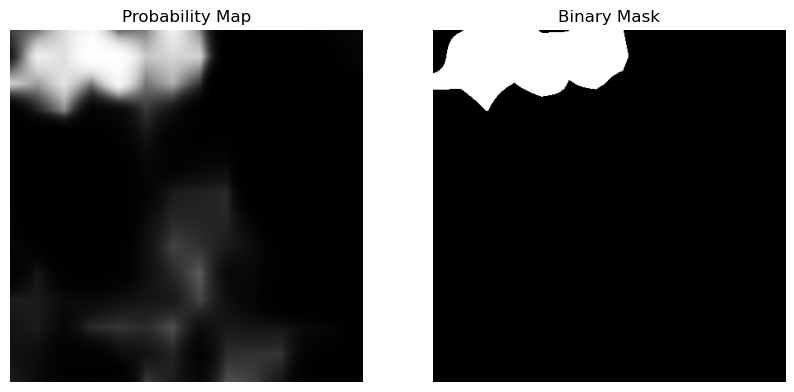

In [63]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    outputs = model(pixel_values.to(device))  # Forward pass through the model

# Upsample the output to match the original image size, if necessary
upsampled_logits = torch.nn.functional.interpolate(outputs,
                                                   size=(448, 448),
                                                   mode='bilinear', align_corners=False)

# Convert the logits to probabilities
predicted_probabilities = torch.sigmoid(upsampled_logits).squeeze().cpu().numpy()

# Convert probabilities to binary mask
predicted_binary_mask = (predicted_probabilities > 0.5).astype(np.uint8)

# Plot both the probability map and the binary mask side-by-side
plt.figure(figsize=(10, 5))

# Plot the probability map
plt.subplot(1, 2, 1)
plt.imshow(predicted_probabilities, cmap='gray')
plt.title('Probability Map')
plt.axis('off')

# Plot the binary mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_binary_mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

plt.show()

In [64]:
binary_mask_image = Image.fromarray(predicted_binary_mask * 255)  # Scale binary mask to 0-255
binary_mask_image.save('/explore/nobackup/people/sking11/saved_figures/predictedmaskCNN50_5000.png')

In [65]:
model.eval()  # Set the model to evaluation mode
predicted_arrays = []  # List to store the predicted arrays

with torch.no_grad():
    for i, (images, _) in enumerate(tqdm(val_loader, desc="Running predictions")):
        images = images.to(device)
        outputs = model(images)
        
        # Iterate through each image in the batch
        for j in range(outputs.size(0)):
            predicted_map = outputs[j].squeeze(0)  # Assuming it's a single-channel output
            predicted_map_np = predicted_map.cpu().numpy()
            
            # Apply threshold to convert to binary
            predicted_map_np = (predicted_map_np > 0.5).astype(np.uint8)
            
            # Optionally, convert to 8-bit integers if needed
            # predicted_map_np = (predicted_map_np * 255).astype(np.uint8)
            
            # Save the numpy array to the list
            predicted_arrays.append(predicted_map_np)

Running predictions: 100%|██████████| 327/327 [00:11<00:00, 27.86it/s]


In [20]:
val_masks_list = []

# Iterate over the validation dataset
for idx in tqdm(range(len(val_dataset)), desc="Processing validation masks"):
    _, mask = val_dataset[idx]  # Get the mask from the dataset
    
    # Convert mask tensor to NumPy array
    mask_np = mask.squeeze(0).cpu().numpy()  # Remove channel dimension and move to CPU if necessary
    
    # Ensure mask values are binary (0 or 1)
    mask_np = (mask_np > 0.5).astype(np.uint8)
    
    # Append to the list
    val_masks_list.append(mask_np)

Processing validation masks: 100%|██████████| 653/653 [00:07<00:00, 84.24it/s] 


In [66]:
# Initialize counters for total correct predictions and total pixels
total_correct = 0
total_pixels = 0

# Loop through each pair of predicted and original masks
for predicted_mask, original_mask in zip(predicted_arrays, val_masks_list):
    # Ensure both masks have the same shape
    assert predicted_mask.shape == original_mask.shape, "Shape mismatch between predicted and original masks"
    
    # Flatten the masks to 1D arrays for easier comparison
    predicted_mask_flat = predicted_mask.flatten()
    original_mask_flat = original_mask.flatten()
    
    # Count the number of correct predictions
    total_correct += np.sum(predicted_mask_flat == original_mask_flat)
    
    # Count the total number of pixels
    total_pixels += original_mask_flat.size

# Calculate the total accuracy
total_accuracy = total_correct / total_pixels

print(f'Total Accuracy: {total_accuracy}')

Total Accuracy: 0.970365248475443


In [67]:
import numpy as np

def calculate_iou(predicted_mask, actual_mask):
    # Ensure the masks are binary (0 and 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    actual_mask = (actual_mask > 0.5).astype(np.uint8)

    # Calculate intersection and union
    intersection = np.logical_and(predicted_mask, actual_mask)
    union = np.logical_or(predicted_mask, actual_mask)

    # Compute IoU
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_mean_iou(predicted_masks, actual_masks):
    ious = []

    for pred, actual in zip(predicted_masks, actual_masks):
        iou = calculate_iou(pred, actual)
        ious.append(iou)

    mean_iou = np.mean(ious)
    return mean_iou

mean_iou = calculate_mean_iou(predicted_arrays, val_masks_list)
print(f"Mean IoU: {mean_iou:.4f}")

Mean IoU: 0.5319


In [68]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Flatten all masks and concatenate them into single arrays
actual_flat = np.concatenate([mask.flatten() for mask in val_masks_list])
predicted_flat = np.concatenate([mask.flatten() for mask in predicted_arrays])

# Ensure only two classes: 0 and 1
assert np.all(np.isin(actual_flat, [0, 1])), "Actual masks contain values other than 0 and 1"
assert np.all(np.isin(predicted_flat, [0, 1])), "Predicted masks contain values other than 0 and 1"

# Calculate the confusion matrix
conf_matrix = confusion_matrix(actual_flat, predicted_flat, labels=[0, 1])

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[119399068   2620633]
 [  1263289   7776722]]


In [69]:
# Calculate accuracy for each tile
accuracies = []
for actual_mask, predicted_mask in zip(val_masks_list, predicted_arrays):
    # Ensure both masks have the same shape
    assert actual_mask.shape == predicted_mask.shape, "Mismatch in mask shapes"
    
    # Calculate the number of correctly predicted pixels
    correct_pixels = np.sum(actual_mask == predicted_mask)
    total_pixels = actual_mask.size
    accuracy = correct_pixels / total_pixels
    
    accuracies.append(accuracy)

# Now, accuracies contains the accuracy for each tile
for idx, acc in enumerate(accuracies):
    print(f"Tile {idx}: Accuracy = {acc:.4f}")

Tile 0: Accuracy = 0.9870
Tile 1: Accuracy = 0.9602
Tile 2: Accuracy = 0.9046
Tile 3: Accuracy = 0.9929
Tile 4: Accuracy = 0.9796
Tile 5: Accuracy = 0.9434
Tile 6: Accuracy = 0.9912
Tile 7: Accuracy = 0.9605
Tile 8: Accuracy = 0.9780
Tile 9: Accuracy = 0.9800
Tile 10: Accuracy = 0.9743
Tile 11: Accuracy = 0.9833
Tile 12: Accuracy = 0.9602
Tile 13: Accuracy = 0.9681
Tile 14: Accuracy = 0.9966
Tile 15: Accuracy = 0.9862
Tile 16: Accuracy = 0.9993
Tile 17: Accuracy = 0.9844
Tile 18: Accuracy = 0.9891
Tile 19: Accuracy = 0.9872
Tile 20: Accuracy = 0.9550
Tile 21: Accuracy = 0.9885
Tile 22: Accuracy = 0.9858
Tile 23: Accuracy = 0.8994
Tile 24: Accuracy = 0.9485
Tile 25: Accuracy = 0.9800
Tile 26: Accuracy = 0.9597
Tile 27: Accuracy = 0.9831
Tile 28: Accuracy = 0.9626
Tile 29: Accuracy = 0.9928
Tile 30: Accuracy = 0.9567
Tile 31: Accuracy = 0.9874
Tile 32: Accuracy = 0.9961
Tile 33: Accuracy = 0.9374
Tile 34: Accuracy = 0.9847
Tile 35: Accuracy = 0.9939
Tile 36: Accuracy = 0.9662
Tile 37: Ac

In [70]:
import csv

# Specify the full file path
file_path = '/explore/nobackup/people/sking11/accuracies/CNN50_5000_accuracies.csv'

# Save as CSV using csv module
with open(file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Tile', 'Accuracy'])  # Write the header
    for idx, accuracy in enumerate(accuracies):
        writer.writerow([idx, accuracy])